# Downloads and imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gpiosenka/100-bird-species
! unzip 100-bird-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/WHITE NECKED RAVEN/028.jpg  
  inflating: train/WHITE NECKED RAVEN/029.jpg  
  inflating: train/WHITE NECKED RAVEN/030.jpg  
  inflating: train/WHITE NECKED RAVEN/031.jpg  
  inflating: train/WHITE NECKED RAVEN/032.jpg  
  inflating: train/WHITE NECKED RAVEN/033.jpg  
  inflating: train/WHITE NECKED RAVEN/034.jpg  
  inflating: train/WHITE NECKED RAVEN/035.jpg  
  inflating: train/WHITE NECKED RAVEN/036.jpg  
  inflating: train/WHITE NECKED RAVEN/037.jpg  
  inflating: train/WHITE NECKED RAVEN/038.jpg  
  inflating: train/WHITE NECKED RAVEN/039.jpg  
  inflating: train/WHITE NECKED RAVEN/040.jpg  
  inflating: train/WHITE NECKED RAVEN/041.jpg  
  inflating: train/WHITE NECKED RAVEN/042.jpg  
  inflating: train/WHITE NECKED RAVEN/043.jpg  
  inflating: train/WHITE NECKED RAVEN/044.jpg  
  inflating: train/WHITE NECKED RAVEN/045.jpg  
  inflating: train/WHITE NECKED RAVEN/046.jpg  
  inflating: train/WHITE NECKED RAVEN

In [3]:
!pip install lightning>=2.0

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

import time
import random
import shutil
from torchmetrics.functional import accuracy

from torchvision import datasets
import torch
from torch import nn
from torchvision.transforms import ToTensor,Lambda
from torchvision import transforms
from torchmetrics import Accuracy
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision.io import read_image
import os
from PIL import Image
import scipy.io as sio
import pandas as pd
import cv2
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

import pytorch_lightning as pl
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from pytorch_lightning.callbacks import EarlyStopping
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

device(type='cuda')

# Functions

In [5]:
def plot_classes(classes):
  fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
  for n, class_name in enumerate(classes):
      class_dir = os.path.join(train_dir, class_name)
      i = n // 5
      j = n % 5
      # get image filenames in class subdirectory
      image_filenames = os.listdir(class_dir)

      # plot first image in class subdirectory with label
      image_filename = image_filenames[0]
      image_path = os.path.join(class_dir, image_filename)
      image = Image.open(image_path)

      axs[i, j].imshow(image)
      axs[i, j].axis('off')
      axs[i, j].set_title(class_name, fontsize=8)

  # adjust spacing between subplots
  plt.subplots_adjust(hspace=0.4)

  # display the figure
  plt.show()

In [6]:
def kf_cv(data, num_classes, v2=False, k=5):
  kfold = KFold(n_splits=k, shuffle=True, random_state=42)
  train_accs, train_losses = [], []
  val_accs, val_losses = [] , []
  
  for fold, (train_indices, val_indices) in enumerate(kfold.split(data)):
      print(f"Fold {fold+1}")
      
      train_set = Subset(data, train_indices)
      val_set = Subset(data, val_indices)

      
      model = BirdsCNN(num_classes=num_classes)
      if v2: model = BirdsCNN2(num_classes=num_classes)

      trainer = pl.Trainer(max_epochs=5)
      train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
      trainer.fit(model, train_loader, val_loader)
      
      # Retain validation metrics
      train_accs.append(model.train_accs)
      train_losses.append(model.train_losses)
      val_accs.append(model.val_accs)
      val_losses.append(model.val_losses)
      # Retain test acc

  kf_dict = {"train_accs": train_accs, 
            "train_losses": train_losses, 
            "val_accs": val_accs,
            "val_losses":val_losses}


  return model, kf_dict

In [7]:
def plot_metrics(metrics_dict, avg=True, k=5):
  train_accs, train_losses, val_accs, val_losses = metrics_dict.values()

  if not avg:
    fig, axs = plt.subplots(k, 2, figsize=(15, 15))
    for i in range(k):
      axs[i, 0].plot(train_losses[i], label='Training')
      axs[i, 0].plot(val_losses[i], label='Validation')
      axs[i, 0].set_title(f'Loss on fold {i}')
      axs[i, 0].set_xlabel('Epoch')
      axs[i, 0].set_ylabel('Loss')
      axs[i, 0].set_xticks(np.arange(len(train_losses[i])+1))
      axs[i, 0].legend()

      axs[i, 1].plot(train_accs[i], label='Training')
      axs[i, 1].plot(val_accs[i], label='Validation')
      axs[i, 1].set_title(f'Accuracy on fold {i}')
      axs[i, 1].set_xlabel('Epoch')
      axs[i, 1].set_ylabel('Accuracy')
      axs[i, 1].set_xticks(np.arange(len(train_accs[i])+1))
      axs[i, 1].legend()

    plt.show()

  else:
    if k!=1:
      train_losses = np.mean(train_losses, axis=0)
      train_accs = np.mean(train_accs, axis=0)
      val_losses = np.mean(val_losses, axis=0)
      val_accs = np.mean(val_accs, axis=0)

    

    # Plot the learning curves
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(train_losses, label='Training')
    axs[0].plot(val_losses, label='Validation')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(train_accs, label='Training')
    axs[1].plot(val_accs, label='Validation')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()

In [8]:
def produce_preds(model, test_loader):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device); model.eval()
  pred_probs, true_labels = [], []

  with torch.no_grad():
      for batch_idx, (data, target) in enumerate(test_loader):
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred_probs.append(output.cpu().numpy())
          true_labels.append(target.cpu().numpy())

  pred_probs = np.concatenate(pred_probs)
  true_labels = np.concatenate(true_labels)
  pred_classes = np.argmax(pred_probs, axis=1)
  
  good_indices, bad_indices, uncertain_indices = [], [], []

  for i in range(len(true_labels)):
    true_label = true_labels[i]
    pred_prob = pred_probs[i][pred_classes[i]]

    if pred_classes[i] == true_label and pred_prob > 0.7:
        good_indices.append(i)
    elif pred_classes[i] != true_label and pred_prob > 0.7:
        bad_indices.append(i)
    elif pred_prob < 0.5:
        uncertain_indices.append(i)

  good_indices = random.sample(good_indices, 3) if len(good_indices) > 3 else good_indices
  bad_indices = random.sample(bad_indices, 3) if len(bad_indices) > 3 else bad_indices 
  uncertain_indices = random.sample(uncertain_indices, 3) if len(uncertain_indices) > 3 else uncertain_indices

  return {"good_indices": good_indices,
          "bad_indices": bad_indices,
          "uncertain_indices": uncertain_indices}

In [9]:
def plot_preds(preds, pred_type):
  if len(preds)==0:
    print(f"No {pred_type} predictions")

  elif len(preds)==1:
    rows = 1; cols = len(preds)
    fig, axs = plt.subplots(rows, cols, figsize=(8, 8))
    axs.set_ylabel(f'{pred_type} predictions')
    
    for col in range(len(preds)):
      img_path = test_loader.dataset.samples[preds[col]][0]
      img = plt.imread(img_path)
      axs.imshow(img)
      axs.set_xticks([])
      axs.set_yticks([])
  
  else:
    rows = 1; cols = len(preds)
    fig, axs = plt.subplots(rows, cols, figsize=(8, 8))
    axs[0].set_ylabel(f'{pred_type} predictions')
    
    for col in range(len(preds)):
      img_path = test_loader.dataset.samples[preds[col]][0]
      img = plt.imread(img_path)
      axs[col].imshow(img)
      axs[col].set_xticks([])
      axs[col].set_yticks([])

    
  plt.show()


In [35]:
def ita(model, test_loader):
  model.eval()
  # iterate over the test set and apply the augmentations to each example
  all_preds = []
  test_labels = []
  for inputs, labels in test_loader:
      batch_size = inputs.size(0)
      test_labels.extend(labels.tolist())
      augmented_inputs = torch.zeros((batch_size*10,) + inputs.size()[1:], dtype=torch.float32)  # create a tensor to hold the augmented examples
      for i in range(batch_size):
          for j in range(10):  # apply 10 different augmentations to each example
              image = transforms.ToPILImage()(inputs[i])
              image = aug_transformer(image)
              augmented_inputs[i*10+j] = image

      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      augmented_inputs = augmented_inputs.to(device)  # send the tensor to GPU if available

      with torch.no_grad():
          # pass the augmented examples through the model to generate predictions
          outputs = model(augmented_inputs)
          outputs = outputs.view(batch_size, 10, -1)
          outputs = torch.mean(outputs, dim=1)  # aggregate the predictions by taking the mean across the augmented examples
          _, preds = torch.max(outputs, 1)
          all_preds.extend(preds.tolist())

  cm = confusion_matrix(test_labels, all_preds)
  accuracy = np.sum(np.diag(cm)) / np.sum(cm)
  return accuracy 

In [11]:
def train(model, train_loader, val_loader, epochs=3):
  min_valid_loss = np.inf
  max_valid_acc = -np.inf
  trainloss = []
  validloss = []
  all_preds = []
  all_targets = []

  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = optim.SGD(model.parameters() , lr = 3e-3 , momentum=0.9)

  for i in range(epochs):
      train_loss = 0.0
      valid_loss = 0.0
      
      model.train()
      for batch_i, (images, target) in enumerate(tqdm(train_loader)):
          images = images.to(device)
          target = target.to(device)
          
          optimizer.zero_grad()
          output = model(images) 
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          
          train_loss = train_loss + ((1/(batch_i+1)) * (loss.data - train_loss))
          trainloss.append(train_loss)
          
      model.eval()
      for batch_i, (images, target) in enumerate(tqdm(val_loader)):
          images = images.to(device)
          target = target.to(device)
          all_targets.extend(target.tolist())

          optimizer.zero_grad()
          output = model(images)
          _, preds = torch.max(output, 1)
          all_preds.extend(preds.tolist())
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          
          valid_loss = valid_loss + ((1/(batch_i+1)) * (loss.data - valid_loss))
          validloss.append(valid_loss)
          
      print("Epoch: {}, Batch: {}, Training Loss: {}, Vaildation Loss: {}".format(i+1, batch_i+1, train_loss, valid_loss))
      
      if valid_loss < min_valid_loss:
          print("Validation Loss Change from {} ---> {}".format(min_valid_loss, valid_loss))
          min_valid_loss = valid_loss

      cm = confusion_matrix(all_targets, all_preds)
      valid_acc = np.sum(np.diag(cm)) / np.sum(cm)

      if valid_acc > max_valid_acc:
          print("Validation Accuracy Change from {} ---> {}".format(max_valid_acc, valid_acc))
          max_valid_acc = valid_acc
      
  return max_valid_acc, min_valid_loss
      

In [12]:
def test_tl_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.cuda(), labels.cuda()
            all_labels.extend(labels.tolist())
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    loss = F.cross_entropy(outputs, labels).item()
    
    unique_correct = set()
    unique_errors = set()
    
    for i, (label, pred) in enumerate(zip(all_labels, all_preds)):
        if label == pred:
            unique_correct.add(i)
        else:
            unique_errors.add(i)
    
    return accuracy, loss, unique_correct, unique_errors

#1. EDA

## a. The size of the data


In [13]:
birds = pd.read_csv("/content/birds.csv")
birds

class id                      filepaths           labels data set  \
0             0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train   
1             0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train   
2             0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER    train   
3             0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER    train   
4             0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER    train   
...         ...                            ...              ...      ...   
87869       514         valid/ZEBRA DOVE/1.jpg       ZEBRA DOVE    valid   
87870       514         valid/ZEBRA DOVE/2.jpg       ZEBRA DOVE    valid   
87871       514         valid/ZEBRA DOVE/3.jpg       ZEBRA DOVE    valid   
87872       514         valid/ZEBRA DOVE/4.jpg       ZEBRA DOVE    valid   
87873       514         valid/ZEBRA DOVE/5.jpg       ZEBRA DOVE    valid   

            scientific name  
0      MALACOCINCLA ABBOTTI  
1      MALACOCINCLA ABBOTTI  
2      MALACOCINCLA ABBOTTI  
3      MALACOCINCLA ABBOTTI  
4      MALACOCINCLA ABBOTTI  
...                     ...  
87869      GEOPELIA STRIATA  
87870      GEOPELIA STRIATA  
87871      GEOPELIA STRIATA  
87872      GEOPELIA STRIATA  
87873      GEOPELIA STRIATA  

[87874 rows x 5 columns]

In [14]:
birds['data set'].value_counts()

train    82724
test      2575
valid     2575
Name: data set, dtype: int64

**We can see that the data is poorly distributed, so we will re distribute the data to 70% train, 20% test and 10% validation**

In [15]:
for j, bird_class in enumerate(tqdm(os.listdir('train'))):
  files = os.listdir(f'train/{bird_class}')
  num = len(files)
  n_to_val, n_to_test = int(num * .1), int(num * .2)
  to_val = random.sample(files, n_to_val)
  files = [f for f in files if f not in to_val]
  to_test = random.sample(files, n_to_test)
  files = [f for f in files if f not in to_test]
  for f in to_val:
    shutil.move(f"train/{bird_class}/{f}", f"valid/{bird_class}/_{f}")
  for f in to_test:
    shutil.move(f"train/{bird_class}/{f}", f"test/{bird_class}/_{f}")

100%|██████████| 515/515 [00:00<00:00, 753.97it/s]


In [16]:
num_tr, num_tst, num_val = 0, 0, 0
for j, bird_class in enumerate(os.listdir('train')):
  files = os.listdir(f'train/{bird_class}')
  num_tr += len(files)

for j, bird_class in enumerate(os.listdir('train')):
  files = os.listdir(f'test/{bird_class}')
  num_tst += len(files)

for j, bird_class in enumerate(os.listdir('train')):
  files = os.listdir(f'valid/{bird_class}')
  num_val += len(files)

In [17]:
print("Size of data after redistributing:")
print("train    " + str(num_tr) + "\n" + "test     " + str(num_tst) + "\n" + "valid    " + str(num_val))

Size of data after redistributing:
train    58312
test     18921
valid    10641


## b. Metadata

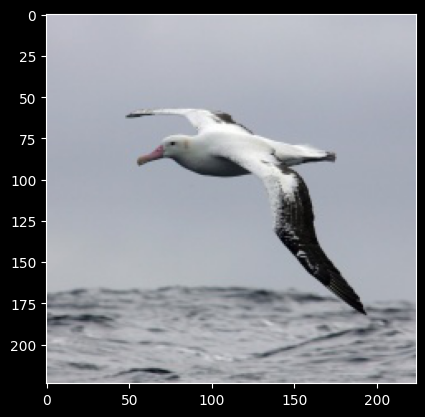

In [ ]:
image_path = '/content/test/ALBATROSS/1.jpg'
# read image using imread
image = plt.imread(image_path)
# display image using imshow
plt.imshow(image)
# show the plot
plt.show()

In [ ]:
# get shape of image
height, width, channels = image.shape
print(f'Image shape: {height} x {width} x {channels}')

Image shape: 224 x 224 x 3


In [ ]:
print(f"the number of classes is: {len(np.unique(birds['scientific name']))}")

the number of classes is: 512


We will need to preprocess the data to handle imbalances (if there are), analyze the image properties, make the model invariant to brightness, backgrounds, placement, etc. by using augmentation, and normalizing the data.

## c. Checking if the data is balanced

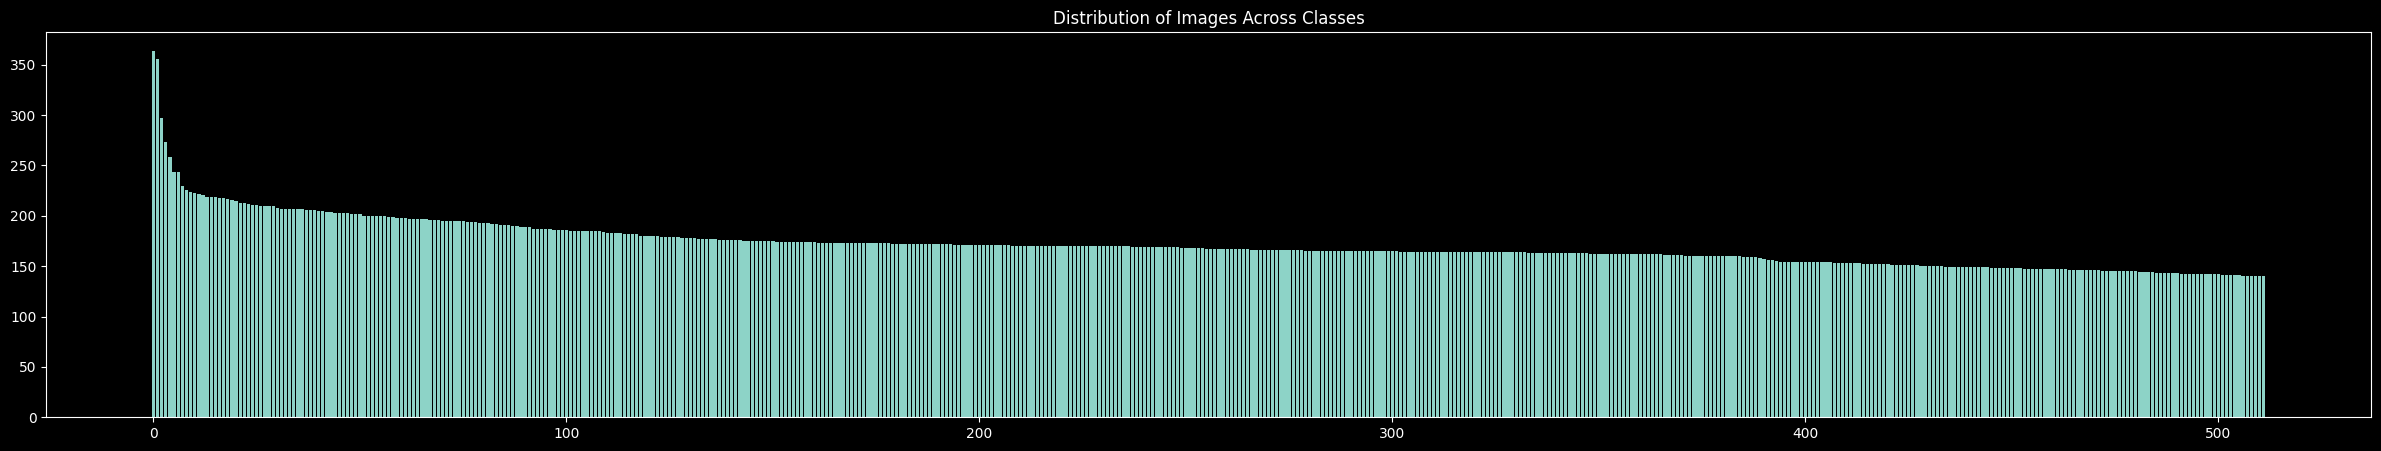

In [ ]:
# Lets check the data distribution
birds_dist = birds['scientific name'].value_counts().reset_index(drop=True)
plt.figure(figsize=(30,5))
plt.bar(birds_dist.index, birds_dist)
plt.title('Distribution of Images Across Classes')
plt.show()


In [ ]:
pd.Series(birds_dist).describe()

count    512.000000
mean     171.628906
std       24.074472
min      140.000000
25%      160.000000
50%      167.000000
75%      178.250000
max      364.000000
Name: scientific name, dtype: float64

As we can see, the data is a bit imbalanced, but this is not a significant enough differnece in which the model might prepfer "guessing" the common classes.

## d. Benchmark result

We will train a one layer model for out benchmark since it like training a logitrics regression model (for time saving puposes)

In [ ]:
# Define the device for computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up data loading and preprocessing
batch_size = 64
transform = transforms.Compose([
    transforms.Resize((25, 25)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder('/content/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set up logistic regression model
num_classes = len(train_dataset.classes)
logreg_model = torch.nn.Linear(25 * 25 * 3, num_classes).to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(logreg_model.parameters(), lr=0.01)

# Train the model using batches
for x_batch, y_batch in tqdm(train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    # Flatten the input images
    x_batch = x_batch.view(x_batch.size(0), -1)

    # Compute the forward pass
    y_pred = logreg_model(x_batch)

    # Compute the loss and backpropagate the gradients
    loss = criterion(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 912/912 [02:06<00:00,  7.24it/s]


In [ ]:
val_dataset = ImageFolder('/content/valid', transform=transform)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Calculate accuracy on validation set
logreg_model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for x_val, y_val in val_loader:
        # Move data to the device
        x_val = x_val.to(device)
        y_val = y_val.to(device)

        # Flatten the input data
        x_val = x_val.view(x_val.size(0), -1)

        # Make predictions
        outputs = logreg_model(x_val)

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Update counts
        total += y_val.size(0)
        correct += (predicted == y_val).sum().item()

# Calculate and print accuracy
accuracy = correct / total
print('Accuracy on validation set: {:.4f}'.format(accuracy))

Accuracy on validation set: 0.0100


## e. Class plotting

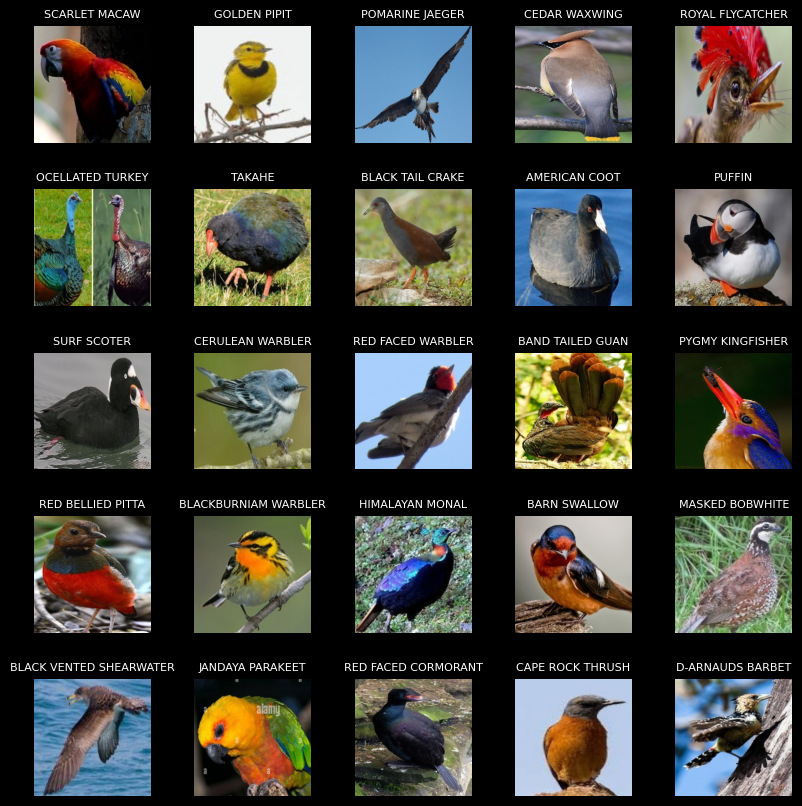

In [ ]:
train_dir = '/content/train'
class_names = os.listdir(train_dir)
plot_classes(class_names[:25])

# Data loading & transformers creation

In [18]:
batch_size = 32

transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.ColorJitter()
])

aug_transformer = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()])

In [19]:
train_data = ImageFolder('/content/train', transform=transformer)
val_data = ImageFolder('/content/valid', transform=transformer)
test_data = ImageFolder('/content/test', transform=transformer)
aug_train_data = ImageFolder('/content/train', transform=aug_transformer)
aug_val_data = ImageFolder('/content/valid', transform=aug_transformer)

num_classes = len(train_data.classes)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data,batch_size=batch_size, shuffle=False, num_workers=4)

# 2. Basic Neural network

## a. Model fitting and result analysis

In [21]:
class BirdsCNN(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=32*56*56, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)

        self.train_accs = []
        self.val_accs = []
        self.test_accs = []

        self.train_losses = []
        self.val_losses = []
        self.test_losses = []

        self.training_step_outputs = []
        self.validation_step_outputs = []


    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        train_loss = nn.functional.cross_entropy(y_hat, y)
        num_correct = sum(torch.argmax(y_hat, dim=1) == y)
        num_total = len(y)
        train_acc = num_correct / num_total
        
        self.training_step_outputs.append({'loss': train_loss, 'acc': train_acc})

        return train_loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        val_loss = nn.functional.cross_entropy(y_hat, y)
        num_correct = sum(torch.argmax(y_hat, dim=1) == y)
        num_total = len(y)
        val_acc = num_correct / num_total
        
        self.validation_step_outputs.append({'loss': val_loss, 'acc': val_acc})

        return val_loss


    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = nn.functional.cross_entropy(y_hat, y)
        num_correct = sum(torch.argmax(y_hat, dim=1) == y)
        num_total = len(y)
        test_acc = num_correct / num_total

        return {'loss': test_loss, 'acc': test_acc}


    def on_train_epoch_end(self):
        train_loss = torch.stack([x['loss'] for x in self.training_step_outputs]).mean()
        train_acc = torch.stack([x['acc'] for x in self.training_step_outputs]).mean()
        self.log('train_loss', train_loss, prog_bar=True)
        self.log('train_acc', train_acc, prog_bar=True)
        self.train_losses.append(train_loss.item())
        self.train_accs.append(train_acc.item())
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        val_loss = torch.stack([x['loss'] for x in self.validation_step_outputs]).mean()
        val_acc = torch.stack([x['acc'] for x in self.validation_step_outputs]).mean()
        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_acc', val_acc, prog_bar=True)
        self.val_losses.append(val_loss.item())
        self.val_accs.append(val_acc.item())
        self.validation_step_outputs.clear()
        self.validation_step_outputs.clear()


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [42]:
data = train_data + val_data
model, kf_metrics = kf_cv(data, num_classes=num_classes, k=k)

Fold 1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 448   
1 | conv2 | Conv2d    | 4.6 K 
2 | pool  | MaxPool2d | 0     
3 | fc1   | Linear    | 25.7 M
4 | fc2   | Linear    | 132 K 
------------------------------------
25.8 M    Trainable params
0         Non-trainable params
25.8 M    Total params
103.311   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Fold 2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 448   
1 | conv2 | Conv2d    | 4.6 K 
2 | pool  | MaxPool2d | 0     
3 | fc1   | Linear    | 25.7 M
4 | fc2   | Linear    | 132 K 
------------------------------------
25.8 M    Trainable params
0         Non-trainable params
25.8 M    Total params
103.311   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Fold 3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 448   
1 | conv2 | Conv2d    | 4.6 K 
2 | pool  | MaxPool2d | 0     
3 | fc1   | Linear    | 25.7 M
4 | fc2   | Linear    | 132 K 
------------------------------------
25.8 M    Trainable params
0         Non-trainable params
25.8 M    Total params
103.311   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Fold 4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 448   
1 | conv2 | Conv2d    | 4.6 K 
2 | pool  | MaxPool2d | 0     
3 | fc1   | Linear    | 25.7 M
4 | fc2   | Linear    | 132 K 
------------------------------------
25.8 M    Trainable params
0         Non-trainable params
25.8 M    Total params
103.311   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Fold 5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 448   
1 | conv2 | Conv2d    | 4.6 K 
2 | pool  | MaxPool2d | 0     
3 | fc1   | Linear    | 25.7 M
4 | fc2   | Linear    | 132 K 
------------------------------------
25.8 M    Trainable params
0         Non-trainable params
25.8 M    Total params
103.311   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [43]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  
test_acc = correct / total
print(f"The test accuracy is {test_acc}")

100%|██████████| 592/592 [03:14<00:00,  3.04it/s]

The test accuracy is 0.24443739760054967


### Plotting the metrics for each fold

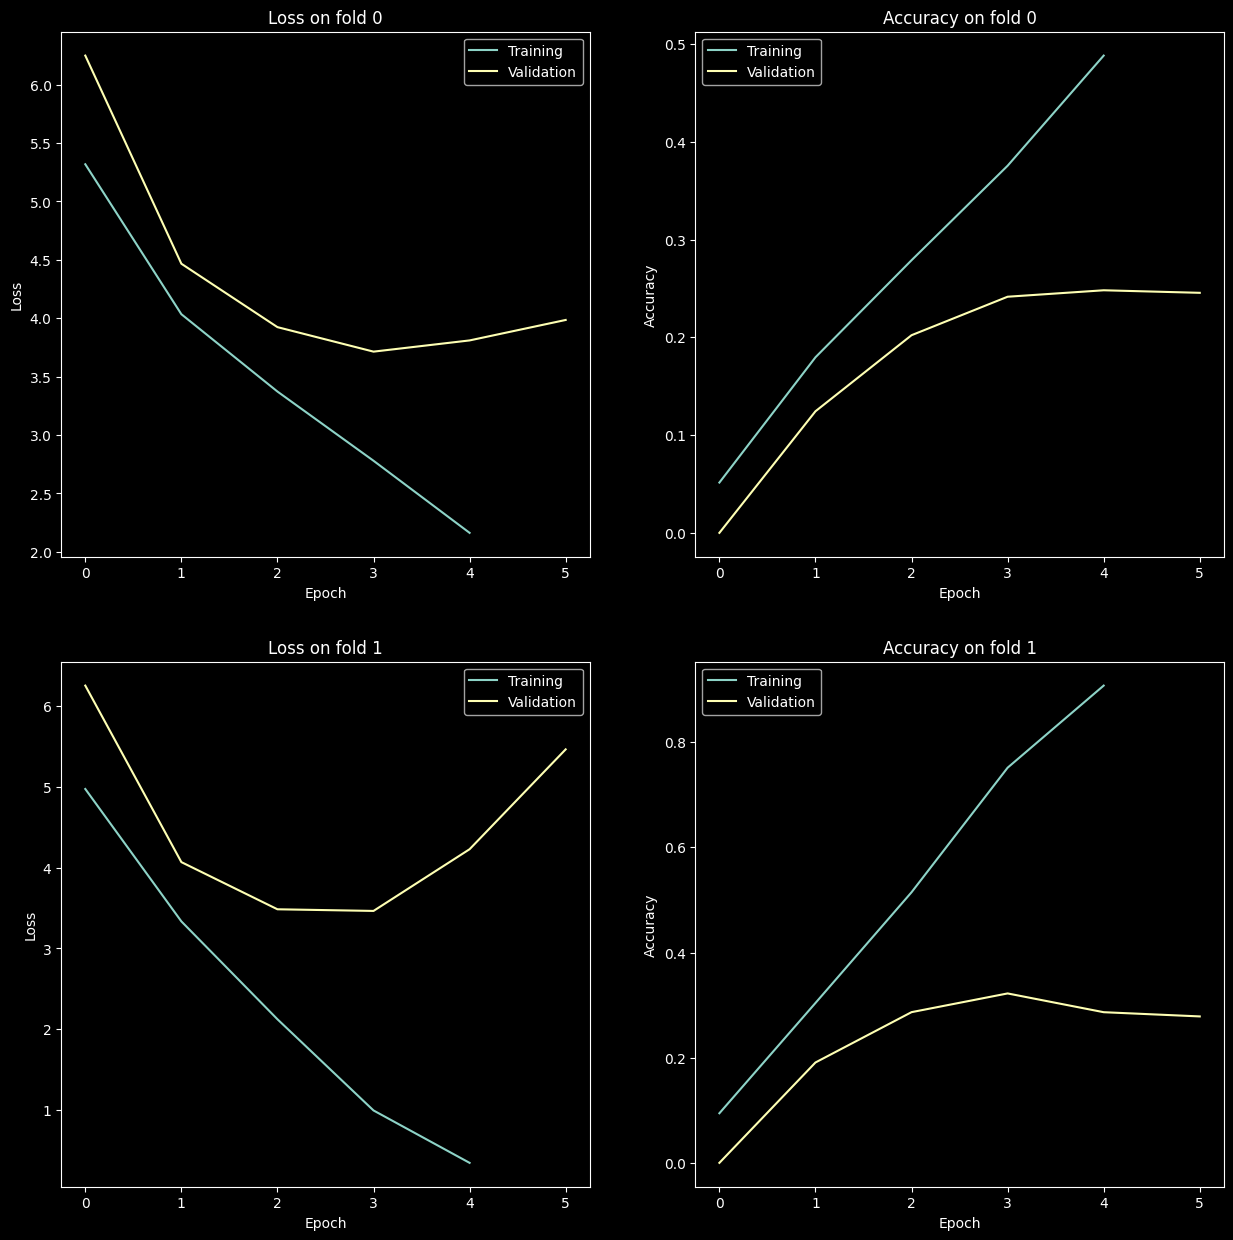

In [44]:
plot_metrics(kf_metrics, avg=False)

### Plotting the mean metrics

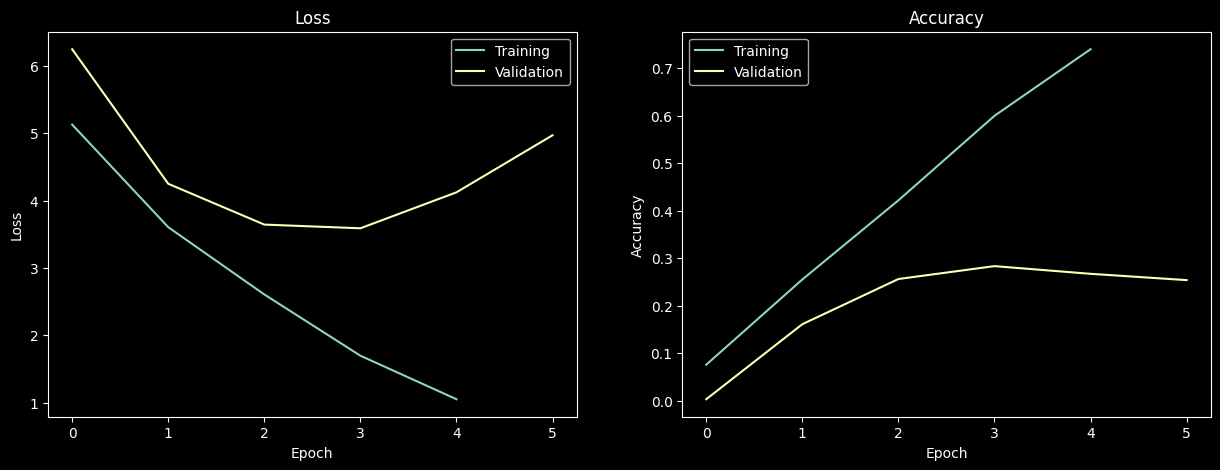

In [45]:
plot_metrics(kf_metrics, avg=True)

As we can see from the leraning curves, the model is overfitted on the data. But this is a good thing, because we learned that the is to overfit first, then try to add data via augmentation, using regularization, etc.

### Looking at the predicitons

In [46]:
preds_dics = produce_preds(model, test_loader)

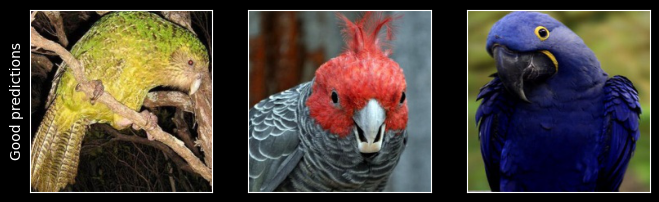

In [47]:
plot_preds(preds_dics['good_indices'], 'Good')

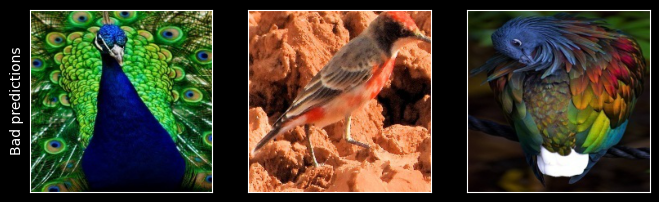

In [48]:
plot_preds(preds_dics['bad_indices'], 'Bad')

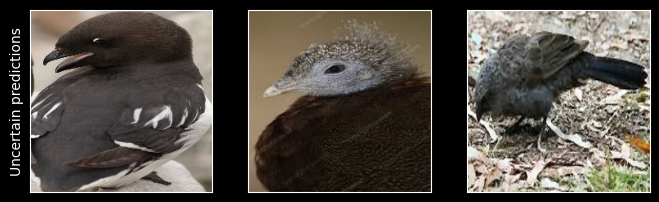

In [49]:
plot_preds(preds_dics['uncertain_indices'], 'Uncertain')

## b. Why the model is misclassifying and improvements

From looking at the bad predictions, we can see that the bird species the are hard to classify are complex or ambiguous classes - Some classes may be more complex or ambiguous than others, making it difficult for the model to distinguish between them. For example, different bird species may have similar physical characteristics, making it difficult for the model to accurately classify them.

Another reaseon might be poor hyperparameter tuning - The model's hyperparameters, such as learning rate or batch size, may not be optimized for the specific task or dataset, resulting in suboptimal performance and misclassifications.

There is another very important reason - inappropriate model architecture: The model architecture may not be suitable for the particular task or dataset being used, resulting in poor performance and misclassifications. We might have not used common practices in artichture modeling such as batch normalization and pooling.

The ways we could improve the model perforence are (in priorotized manner):
1. Data augmentation: Increasing the diversity of the training data by using techniques such as random crops, flips, rotations, and color jittering can help the model learn more robust and discriminative features. This is often one of the most effective ways to improve performance.
2. Architecture modification: Experimenting with different architectures or modifying the existing one can help to better capture the underlying patterns in the data. This could include changes such as increasing the depth or width of the network, adding more layers, or incorporating skip connections.
3. Hyperparameter tuning: Fine-tuning the hyperparameters of the model, such as the learning rate, weight decay, and batch size, can lead to better convergence and generalization. This can be done using methods such as random or grid search, or more advanced techniques such as Bayesian optimization.
4. Ensemble methods: Combining multiple models trained with different hyperparameters, architectures, or data subsets can help to reduce the impact of random initialization and improve overall performance. This could include techniques such as bagging, boosting, or stacking.

## c. Implemnting the first 2 suggestions

In [22]:
class BirdsCNN2(BirdsCNN):
    def __init__(self, num_classes):
        super().__init__(num_classes)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=64*56*56, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = F.relu(x) 
        x = self.dropout(x)
        x = self.pool(x)
        
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [24]:
data = aug_train_data + aug_val_data
model, kf_metrics = kf_cv(data, num_classes=num_classes, v2=True)

Fold 1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | conv1   | Conv2d    | 896   
1 | conv2   | Conv2d    | 18.5 K
2 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Fold 2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | conv1   | Conv2d    | 896   
1 | conv2   | Conv2d    | 18.5 K
2 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Fold 3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | conv1   | Conv2d    | 896   
1 | conv2   | Conv2d    | 18.5 K
2 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Fold 4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | conv1   | Conv2d    | 896   
1 | conv2   | Conv2d    | 18.5 K
2 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Fold 5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | conv1   | Conv2d    | 896   
1 | conv2   | Conv2d    | 18.5 K
2 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [25]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  
test_acc = correct / total
print(f"The test accuracy is {test_acc}")


100%|██████████| 592/592 [10:03<00:00,  1.02s/it]

The test accuracy is 0.36525553617673484


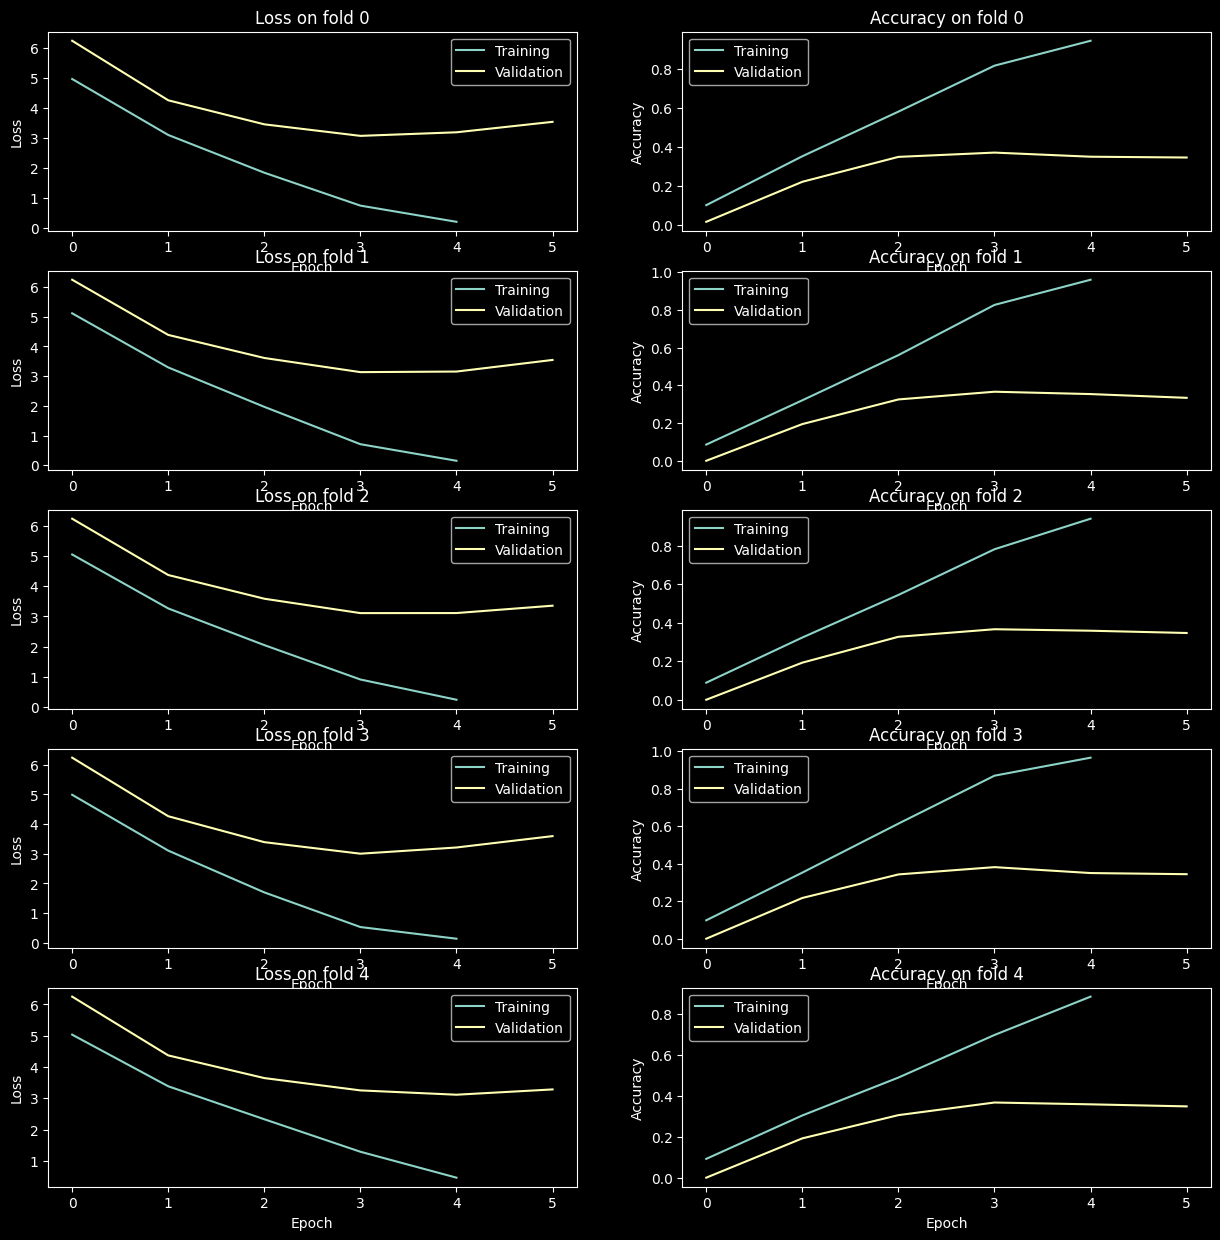

In [26]:
plot_metrics(kf_metrics, avg=False)

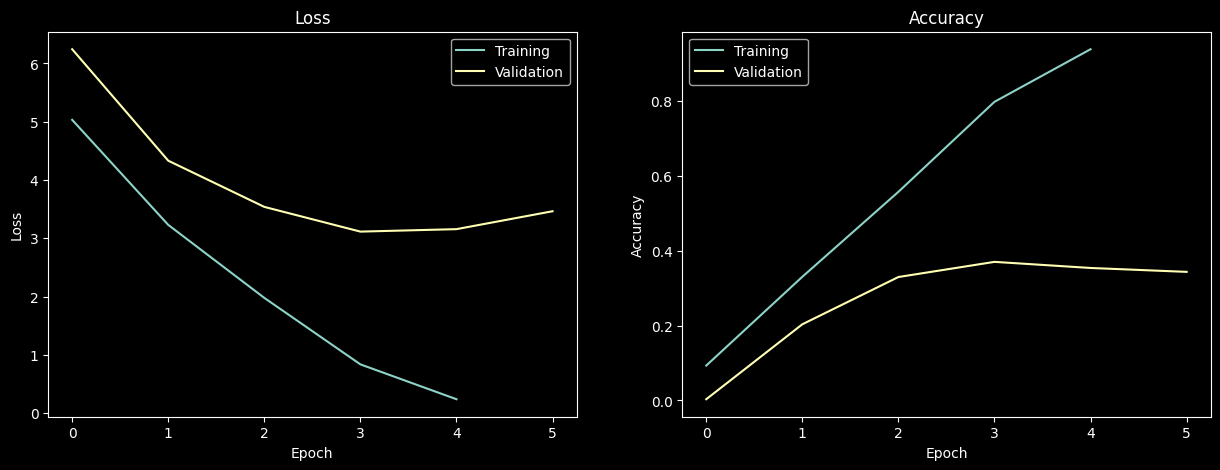

In [27]:
plot_metrics(kf_metrics, avg=True)

In [28]:
preds_dict = produce_preds(model, test_loader)

In [30]:
plot_preds(preds_dict['good_indices'], 'Good')

No Good predictions


In [32]:
plot_preds(preds_dict['bad_indices'], 'Bad')

No Bad predictions


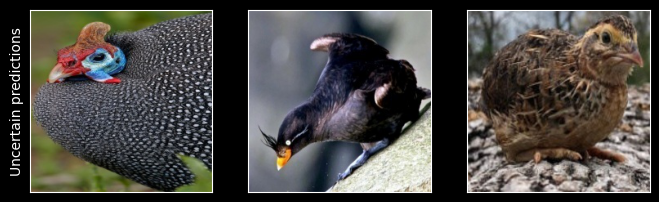

In [33]:
plot_preds(preds_dict['uncertain_indices'], 'Uncertain')

We can see than the model still overfits, that means that we need to add new data, add more sophisticated augmented images.

The model might misclassify now because of:

- Complexity of the problem: Some problems are inherently complex and cannot be solved perfectly by a machine learning model. In such cases, you can try using a more complex model or adding more layers to your existing model to increase its capacity.

- Hyperparameter tuning: The performance of a machine learning model is sensitive to the choice of hyperparameters such as learning rate, batch size, etc. You can try tuning these hyperparameters to improve the model's performance.

- Overfitting: If the model is overfitting to the training data, it might not be able to generalize to new examples. You can mitigate this by further using techniques like early stopping, regularization, and dropout.

We can improve it with:
- Ensemble learning: Combine multiple models to improve the overall performance.

- Transfer learning: Use a pre-trained model as a starting point and fine-tune it on your specific task.

- Model interpretability: Analyze the model's predictions and try to identify patterns in the misclassifications. This can help you understand the limitations of the model and suggest areas for improvement.


## d. Inference Time Augmentation

In [38]:
acc = ita(model, test_loader)
print(f"Accuracy is: {acc}")

Accuracy is: 0.3855663019924951


As we can see, this is an improvement of ~2%

## e. Adding a new species

We decided to add the BLUE JAY species.

In [ ]:
!unzip /content/BLUE_JAY.zip

In [ ]:
# set the paths to the existing dataset and the new blue jay dataset
blue_jay_dir = "/content/BLUE_JAY"

# create a new dataset object by combining the existing dataset and the blue jay dataset
combined_dataset = train_data + ImageFolder(root=blue_jay_dir, transform=transformer)

# define the DataLoader for the combined dataset
train_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# define your model architecture

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model on the combined dataset
epochs = 5
for _ in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 3. Transfer learning

## a.+b.+c. Creating the TL table

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pretrained_models = pretrained_models = {"GoogLeNet": models.googlenet(pretrained=True),
                                         "ResNet50": models.resnet50(pretrained=True),
                                         "ResNeXt": models.resnext101_32x8d(pretrained=True),
                                         "VGG16": models.vgg16(pretrained=True)}

models_df = pd.DataFrame(columns=['params', 'val_loss', 
                                  'val_acc', 
                                  'test_loss', 
                                  'test_acc', 
                                  'unique_correct', 
                                  'unique_errors',
                                  'time'])

In [25]:
for i, (name, model) in enumerate(pretrained_models.items()):
    for param in model.parameters():
        param.requires_grad_(False)

    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, len(train_data.classes)))
        
    elif hasattr(model, 'classifier'):
        model.classifier = nn.Sequential(
          nn.Linear(25088, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(),
          nn.Linear(4096, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(),
          nn.Linear(4096, len(train_data.classes)))
        
    model.to(device) 

    start_time = time.time()
    val_acc, val_loss = train(model, train_loader, val_loader, epochs=10)
    test_acc, test_loss, unique_correct, unique_errors = test_tl_model(model, test_loader)
    end_time = time.time()
    elapsed_time = end_time - start_time

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    models_df = models_df.append({'model': name,
                                  'params': num_params,
                                  'val_loss': val_loss.item(),
                                  'val_acc': val_acc.item(),
                                  'test_loss': test_loss,
                                  'test_acc': test_acc,
                                  'unique_correct': len(unique_correct),
                                  'unique_errors': len(unique_errors),
                                  'time': elapsed_time}, 
                                 ignore_index=True)

100%|██████████| 333/333 [00:09<00:00, 34.93it/s]


Epoch: 1, Batch: 333, Training Loss: 5.0805344581604, Vaildation Loss: 2.845954418182373
Validation Loss Change from inf ---> 2.845954418182373
Validation Accuracy Change from -inf ---> 0.47984212010149424


100%|██████████| 333/333 [00:09<00:00, 35.04it/s]


Epoch: 2, Batch: 333, Training Loss: 2.285142183303833, Vaildation Loss: 1.4058009386062622
Validation Loss Change from 2.845954418182373 ---> 1.4058009386062622
Validation Accuracy Change from 0.47984212010149424 ---> 0.5860351470726436


100%|██████████| 333/333 [00:09<00:00, 35.39it/s]


Epoch: 3, Batch: 333, Training Loss: 1.596458911895752, Vaildation Loss: 1.0175992250442505
Validation Loss Change from 1.4058009386062622 ---> 1.0175992250442505
Validation Accuracy Change from 0.5860351470726436 ---> 0.6481220436675751


100%|██████████| 333/333 [00:09<00:00, 35.41it/s]


Epoch: 4, Batch: 333, Training Loss: 1.3407729864120483, Vaildation Loss: 0.8491175174713135
Validation Loss Change from 1.0175992250442505 ---> 0.8491175174713135
Validation Accuracy Change from 0.6481220436675751 ---> 0.6866365943050465


100%|██████████| 333/333 [00:09<00:00, 35.39it/s]


Epoch: 5, Batch: 333, Training Loss: 1.1953054666519165, Vaildation Loss: 0.7203161120414734
Validation Loss Change from 0.8491175174713135 ---> 0.7203161120414734
Validation Accuracy Change from 0.6866365943050465 ---> 0.7159289540456724


100%|██████████| 333/333 [00:09<00:00, 34.84it/s]


Epoch: 6, Batch: 333, Training Loss: 1.0926064252853394, Vaildation Loss: 0.6365728378295898
Validation Loss Change from 0.7203161120414734 ---> 0.6365728378295898
Validation Accuracy Change from 0.7159289540456724 ---> 0.7382138270212699


100%|██████████| 333/333 [00:09<00:00, 35.32it/s]


Epoch: 7, Batch: 333, Training Loss: 1.0196292400360107, Vaildation Loss: 0.5710383057594299
Validation Loss Change from 0.6365728378295898 ---> 0.5710383057594299
Validation Accuracy Change from 0.7382138270212699 ---> 0.7564944218454227


100%|██████████| 333/333 [00:09<00:00, 35.50it/s]


Epoch: 8, Batch: 333, Training Loss: 0.9620524644851685, Vaildation Loss: 0.5168154239654541
Validation Loss Change from 0.5710383057594299 ---> 0.5168154239654541
Validation Accuracy Change from 0.7564944218454227 ---> 0.7717319800770605


100%|██████████| 333/333 [00:09<00:00, 35.78it/s]


Epoch: 9, Batch: 333, Training Loss: 0.914201557636261, Vaildation Loss: 0.47765806317329407
Validation Loss Change from 0.5168154239654541 ---> 0.47765806317329407
Validation Accuracy Change from 0.7717319800770605 ---> 0.7844918501811651


100%|██████████| 333/333 [00:09<00:00, 35.17it/s]


Epoch: 10, Batch: 333, Training Loss: 0.8745962977409363, Vaildation Loss: 0.43909984827041626
Validation Loss Change from 0.47765806317329407 ---> 0.43909984827041626
Validation Accuracy Change from 0.7844918501811651 ---> 0.7957428813081477


100%|██████████| 333/333 [00:09<00:00, 34.89it/s]


Epoch: 1, Batch: 333, Training Loss: 3.9816441535949707, Vaildation Loss: 1.5525444746017456
Validation Loss Change from inf ---> 1.5525444746017456
Validation Accuracy Change from -inf ---> 0.6566112207499295


100%|██████████| 333/333 [00:09<00:00, 35.56it/s]


Epoch: 2, Batch: 333, Training Loss: 1.3443955183029175, Vaildation Loss: 0.8032324910163879
Validation Loss Change from 1.5525444746017456 ---> 0.8032324910163879
Validation Accuracy Change from 0.6566112207499295 ---> 0.7294427215487266


100%|██████████| 333/333 [00:09<00:00, 34.86it/s]


Epoch: 3, Batch: 333, Training Loss: 0.9538776874542236, Vaildation Loss: 0.5896377563476562
Validation Loss Change from 0.8032324910163879 ---> 0.5896377563476562
Validation Accuracy Change from 0.7294427215487266 ---> 0.7701030604893024


100%|██████████| 333/333 [00:09<00:00, 34.95it/s]


Epoch: 4, Batch: 333, Training Loss: 0.7932367324829102, Vaildation Loss: 0.48153620958328247
Validation Loss Change from 0.5896377563476562 ---> 0.48153620958328247
Validation Accuracy Change from 0.7701030604893024 ---> 0.7971525232590921


100%|██████████| 333/333 [00:09<00:00, 34.85it/s]


Epoch: 5, Batch: 333, Training Loss: 0.6870025396347046, Vaildation Loss: 0.40630778670310974
Validation Loss Change from 0.48153620958328247 ---> 0.40630778670310974
Validation Accuracy Change from 0.7971525232590921 ---> 0.8173855840616483


100%|██████████| 333/333 [00:09<00:00, 35.53it/s]


Epoch: 6, Batch: 333, Training Loss: 0.6163482069969177, Vaildation Loss: 0.35377606749534607
Validation Loss Change from 0.40630778670310974 ---> 0.35377606749534607
Validation Accuracy Change from 0.8173855840616483 ---> 0.8332236945149265


100%|██████████| 333/333 [00:09<00:00, 34.85it/s]


Epoch: 7, Batch: 333, Training Loss: 0.5637605786323547, Vaildation Loss: 0.3061586916446686
Validation Loss Change from 0.35377606749534607 ---> 0.3061586916446686
Validation Accuracy Change from 0.8332236945149265 ---> 0.8464027279928041


100%|██████████| 333/333 [00:09<00:00, 34.55it/s]


Epoch: 8, Batch: 333, Training Loss: 0.519360363483429, Vaildation Loss: 0.2737669050693512
Validation Loss Change from 0.3061586916446686 ---> 0.2737669050693512
Validation Accuracy Change from 0.8464027279928041 ---> 0.8571680293205526


100%|██████████| 333/333 [00:09<00:00, 34.94it/s]


Epoch: 9, Batch: 333, Training Loss: 0.4790355861186981, Vaildation Loss: 0.24002623558044434
Validation Loss Change from 0.2737669050693512 ---> 0.24002623558044434
Validation Accuracy Change from 0.8571680293205526 ---> 0.8667627311551754


100%|██████████| 333/333 [00:09<00:00, 35.18it/s]


Epoch: 10, Batch: 333, Training Loss: 0.44357791543006897, Vaildation Loss: 0.21828114986419678
Validation Loss Change from 0.24002623558044434 ---> 0.21828114986419678
Validation Accuracy Change from 0.8667627311551754 ---> 0.8750023494032516


100%|██████████| 333/333 [00:17<00:00, 18.90it/s]


Epoch: 1, Batch: 333, Training Loss: 3.469855546951294, Vaildation Loss: 1.1692363023757935
Validation Loss Change from inf ---> 1.1692363023757935
Validation Accuracy Change from -inf ---> 0.7353632177426933


100%|██████████| 333/333 [00:17<00:00, 18.88it/s]


Epoch: 2, Batch: 333, Training Loss: 1.0505565404891968, Vaildation Loss: 0.6228049397468567
Validation Loss Change from 1.1692363023757935 ---> 0.6228049397468567
Validation Accuracy Change from 0.7353632177426933 ---> 0.7906681702847477


100%|██████████| 333/333 [00:17<00:00, 18.97it/s]


Epoch: 3, Batch: 333, Training Loss: 0.7385852336883545, Vaildation Loss: 0.4475755989551544
Validation Loss Change from 0.6228049397468567 ---> 0.4475755989551544
Validation Accuracy Change from 0.7906681702847477 ---> 0.8234501769883783


100%|██████████| 333/333 [00:17<00:00, 18.92it/s]


Epoch: 4, Batch: 333, Training Loss: 0.6026788949966431, Vaildation Loss: 0.35748782753944397
Validation Loss Change from 0.4475755989551544 ---> 0.35748782753944397
Validation Accuracy Change from 0.8234501769883783 ---> 0.845879146696739


100%|██████████| 333/333 [00:17<00:00, 18.72it/s]


Epoch: 5, Batch: 333, Training Loss: 0.5196374654769897, Vaildation Loss: 0.29558801651000977
Validation Loss Change from 0.35748782753944397 ---> 0.29558801651000977
Validation Accuracy Change from 0.845879146696739 ---> 0.8622873790057325


100%|██████████| 333/333 [00:17<00:00, 18.77it/s]


Epoch: 6, Batch: 333, Training Loss: 0.4607524871826172, Vaildation Loss: 0.2520640790462494
Validation Loss Change from 0.29558801651000977 ---> 0.2520640790462494
Validation Accuracy Change from 0.8622873790057325 ---> 0.8750430723929455


100%|██████████| 333/333 [00:17<00:00, 18.89it/s]


Epoch: 7, Batch: 333, Training Loss: 0.4120890200138092, Vaildation Loss: 0.22045257687568665
Validation Loss Change from 0.2520640790462494 ---> 0.22045257687568665
Validation Accuracy Change from 0.8750430723929455 ---> 0.8856713251976855


100%|██████████| 333/333 [00:17<00:00, 18.91it/s]


Epoch: 8, Batch: 333, Training Loss: 0.37492096424102783, Vaildation Loss: 0.19134944677352905
Validation Loss Change from 0.22045257687568665 ---> 0.19134944677352905
Validation Accuracy Change from 0.8856713251976855 ---> 0.894594023118128


100%|██████████| 333/333 [00:17<00:00, 18.93it/s]


Epoch: 9, Batch: 333, Training Loss: 0.3388867974281311, Vaildation Loss: 0.16816328465938568
Validation Loss Change from 0.19134944677352905 ---> 0.16816328465938568
Validation Accuracy Change from 0.894594023118128 ---> 0.9022230575656005


100%|██████████| 333/333 [00:17<00:00, 18.79it/s]


Epoch: 10, Batch: 333, Training Loss: 0.3106972575187683, Vaildation Loss: 0.15043649077415466
Validation Loss Change from 0.16816328465938568 ---> 0.15043649077415466
Validation Accuracy Change from 0.9022230575656005 ---> 0.9087773705478809


100%|██████████| 333/333 [00:10<00:00, 31.70it/s]


Epoch: 1, Batch: 333, Training Loss: 4.3800368309021, Vaildation Loss: 1.9724093675613403
Validation Loss Change from inf ---> 1.9724093675613403
Validation Accuracy Change from -inf ---> 0.5165867869561132


100%|██████████| 333/333 [00:10<00:00, 31.67it/s]


Epoch: 2, Batch: 333, Training Loss: 1.8260308504104614, Vaildation Loss: 0.9121022820472717
Validation Loss Change from 1.9724093675613403 ---> 0.9121022820472717
Validation Accuracy Change from 0.5165867869561132 ---> 0.639789493468659


100%|██████████| 333/333 [00:10<00:00, 31.76it/s]


Epoch: 3, Batch: 333, Training Loss: 1.1499135494232178, Vaildation Loss: 0.45883214473724365
Validation Loss Change from 0.9121022820472717 ---> 0.45883214473724365
Validation Accuracy Change from 0.639789493468659 ---> 0.7189487203583623


100%|██████████| 333/333 [00:10<00:00, 31.32it/s]


Epoch: 4, Batch: 333, Training Loss: 0.7801017761230469, Vaildation Loss: 0.2231975793838501
Validation Loss Change from 0.45883214473724365 ---> 0.2231975793838501
Validation Accuracy Change from 0.7189487203583623 ---> 0.7751151207593271


100%|██████████| 333/333 [00:10<00:00, 31.50it/s]


Epoch: 5, Batch: 333, Training Loss: 0.5304577350616455, Vaildation Loss: 0.11724628508090973
Validation Loss Change from 0.2231975793838501 ---> 0.11724628508090973
Validation Accuracy Change from 0.7751151207593271 ---> 0.8149046142279861


100%|██████████| 333/333 [00:10<00:00, 31.96it/s]


Epoch: 6, Batch: 333, Training Loss: 0.36776840686798096, Vaildation Loss: 0.07455857843160629
Validation Loss Change from 0.11724628508090973 ---> 0.07455857843160629
Validation Accuracy Change from 0.8149046142279861 ---> 0.8434044419384144


100%|██████████| 333/333 [00:10<00:00, 31.52it/s]


Epoch: 7, Batch: 333, Training Loss: 0.2640562355518341, Vaildation Loss: 0.047015562653541565
Validation Loss Change from 0.07455857843160629 ---> 0.047015562653541565
Validation Accuracy Change from 0.8434044419384144 ---> 0.8648354746465826


100%|██████████| 333/333 [00:10<00:00, 31.47it/s]


Epoch: 8, Batch: 333, Training Loss: 0.19301238656044006, Vaildation Loss: 0.038267675787210464
Validation Loss Change from 0.047015562653541565 ---> 0.038267675787210464
Validation Accuracy Change from 0.8648354746465826 ---> 0.880897002161451


100%|██████████| 333/333 [00:10<00:00, 32.00it/s]


Epoch: 9, Batch: 333, Training Loss: 0.1556885540485382, Vaildation Loss: 0.027898289263248444
Validation Loss Change from 0.038267675787210464 ---> 0.027898289263248444
Validation Accuracy Change from 0.880897002161451 ---> 0.8936190207687248


100%|██████████| 333/333 [00:10<00:00, 31.52it/s]


Epoch: 10, Batch: 333, Training Loss: 0.12449120730161667, Vaildation Loss: 0.021451352164149284
Validation Loss Change from 0.027898289263248444 ---> 0.021451352164149284
Validation Accuracy Change from 0.8936190207687248 ---> 0.9039845879146696


100%|██████████| 592/592 [00:17<00:00, 33.89it/s]


In [26]:
models_df

params  val_loss   val_acc  test_loss  test_acc unique_correct  \
0    6308355  0.439100  0.795743   0.019898  0.817504          15468   
1   10502659  0.218281  0.875002   0.016558  0.876434          16583   
2   10502659  0.150436  0.908777   0.075221  0.901009          17048   
3  121655811  0.021451  0.903985   0.402454  0.787696          14904   

  unique_errors         time      model  
0          3453   601.361752  GoogLeNet  
1          2338   603.190624   ResNet50  
2          1873  1053.429345    ResNeXt  
3          4017   618.793952      VGG16

## d. Feature extraction

In [21]:
original_model = model

In [ ]:
original_model

In [23]:
modules = list(model.children())[:-1]
model = torch.nn.Sequential(*modules)

features = []
labels = []
model.eval()
with torch.no_grad():
    for inputs, target in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        features.append(outputs.squeeze())
        labels.append(target)

In [24]:
features = torch.cat(features, dim=0).cpu().numpy()
labels = torch.cat(labels, dim=0).numpy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a logistic regression classifier on the extracted features
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)

# Evaluate the classifier on the test set
acc = lr.score(X_test, y_test)
print(f'Logistic regression accuracy: {acc:.2f}')

Logistic regression accuracy: 0.89


The feature extractor combined with a machine learning model achieved good results that were comparable to the performance of a CNN. By using the feature extractor, we were able to extract the most important information from the images and represent them as numerical features. This reduced the amount of data that the model had to learn from, resulting in faster training times and more efficient use of resources. The machine learning model was able to learn the relationships between the extracted features and the labels, resulting in accurate predictions on the test set. Overall, this approach provided a viable alternative to using a CNN for image classification tasks, especially when resources are limited or when the dataset is small.